In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT

In [23]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [24]:
import wandb
wandb.login()

True

In [25]:
image_size = 128
batch_size = 64
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(contrast=0.25, brightness=0.5),
         # transforms.ColorJitter(brightness=0.5)
    ], p=0.5), 
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.5),  
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
])
train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_transform)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_transform, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
image, mask, seg_type = next(iter(train_dataloader))
image = image
mask = mask

In [26]:
image.shape

torch.Size([64, 1, 128, 128])

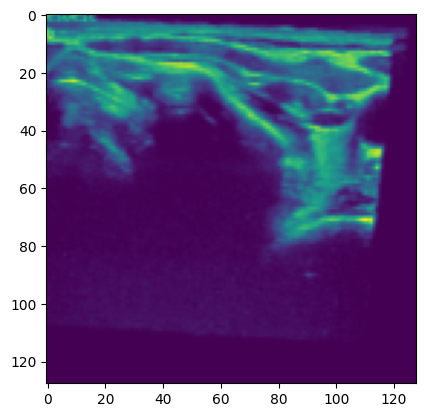

In [27]:
plt.imshow(image[10][0])

In [28]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1)
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

In [29]:
# loss_fn_nodule = StructureLoss()
# loss_fn_gland = StructureLoss()

In [30]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [31]:
# seg_type

In [32]:
# for epoch in range(1000):
#     outputs = model(image)

#     nodule_output = outputs[:, 0:1, :, :][seg_type==1]
#     nodule_mask = mask[seg_type==1]
    
#     gland_output = outputs[:, 1:2, :, :][seg_type==2]
#     gland_mask = mask[seg_type==2]
#     # outputs = torch.sigmoid(logits)
#     # print(nodule_output.shape, nodule_mask.shape)
#     nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
#     gland_loss = loss_fn_gland(gland_output, gland_mask)
    
#     loss = nodule_loss + gland_loss
    
#     IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2
    
#     dice_loss = DiceLoss()
#     # print(dice_loss(nodule_output, nodule_mask))
#     # print(dice_loss(gland_output, gland_mask)) 
#     DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2
    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [33]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(nodule_mask[index][0])
# nodule_output = (nodule_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(nodule_output[index][0].detach().numpy())

In [34]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(gland_mask[index][0])
# gland_output = (gland_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(gland_output[index][0].detach().numpy())

In [35]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        gland_loss = loss_fn_gland(gland_output, gland_mask)


        
        loss = nodule_loss + gland_loss
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2

        dice_loss = DiceLoss()
        DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]
        TN3K_nodule_output = nodule_output[from_dataset==3]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        TN3K_nodule_mask = nodule_mask[from_dataset==3]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [42]:
epochs = 15
lr = 0.01
project = "thyroid"
name=name="PMFSNet_crop_DDTI_standardization_aug_colorjitter(contrast_0.25_brightness_0.5)(0.5)_gaussianblur_3(0.5)_for_finetune"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [43]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 15, batch size : 64


In [44]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[10, 20, 48, 96],
#         # embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = LightMed(in_channels = 1, out_channels = 2, image_size = image_size)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

### If using pretrained model

In [45]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [46]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [47]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_val_loss": DDTI_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TN3K_val_loss": TN3K_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.01it/s]

train loss : 1.436399753731076, train IOU : 0.49908198408235643, train DICE : 0.642153933201686



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.19it/s]

val loss : 0.9857574224472045, val IOU : 0.43496909737586975, val DICE : 0.6040218770503998
epoch : 1



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.00it/s]

train loss : 1.0423375391724086, train IOU : 0.6310997587619441, train DICE : 0.7677061723010374



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.08it/s]

val loss : 0.7920818746089935, val IOU : 0.5013503134250641, val DICE : 0.6664907246828079
epoch : 2



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.00it/s]

train loss : 0.9248287471214144, train IOU : 0.6716309697321146, train DICE : 0.7996663828887561



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.11it/s]

val loss : 0.767436894774437, val IOU : 0.5144287377595902, val DICE : 0.6777803033590317
epoch : 3



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  2.97it/s]

train loss : 0.8493106554050257, train IOU : 0.69945225621214, train DICE : 0.8194154270804754



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.17it/s]

val loss : 0.868735671043396, val IOU : 0.4672561839222908, val DICE : 0.6380593359470368
epoch : 4



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.03it/s]

train loss : 0.771503487435898, train IOU : 0.7276179277070678, train DICE : 0.8381855971742385



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.24it/s]

val loss : 0.7566133379936218, val IOU : 0.5305548399686814, val DICE : 0.6934541225433349
epoch : 5



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.01it/s]

train loss : 0.7228060506358005, train IOU : 0.7464195879379122, train DICE : 0.8513271956160517



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.38it/s]

val loss : 0.7187390118837357, val IOU : 0.5501489505171776, val DICE : 0.7181537121534347
epoch : 6



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.00it/s]

train loss : 0.6720239337127988, train IOU : 0.7629059759697111, train DICE : 0.8636751233941258



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.23it/s]

val loss : 0.6813196301460266, val IOU : 0.5781158804893494, val DICE : 0.7395800173282623
epoch : 7



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.03it/s]

train loss : 0.6204199129992193, train IOU : 0.7815715776811732, train DICE : 0.8769508612037885



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.32it/s]

val loss : 0.7091174572706223, val IOU : 0.5793531268835068, val DICE : 0.7394773542881012
epoch : 8



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:32<00:00,  3.08it/s]

train loss : 0.5776447414761723, train IOU : 0.7987569381694982, train DICE : 0.8862211155419303



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.63it/s]

val loss : 0.6295597165822983, val IOU : 0.6162755846977234, val DICE : 0.761633887887001
epoch : 9



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.06it/s]

train loss : 0.5344353474602841, train IOU : 0.8128368311589307, train DICE : 0.8966113553188815



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.36it/s]

val loss : 0.6097108989953994, val IOU : 0.6293173730373383, val DICE : 0.7729779273271561
epoch : 10



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.03it/s]

train loss : 0.4903292948066598, train IOU : 0.8305800002400238, train DICE : 0.9074965426237276



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.20it/s]

val loss : 0.6403915882110596, val IOU : 0.6248227447271347, val DICE : 0.7782141268253326
epoch : 11



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.03it/s]

train loss : 0.4513832147758786, train IOU : 0.8447573232178641, train DICE : 0.9162908839707328



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.26it/s]

val loss : 0.6666404694318772, val IOU : 0.6270762354135513, val DICE : 0.7827676326036453
epoch : 12



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.02it/s]

train loss : 0.4185891366831147, train IOU : 0.8568894957551861, train DICE : 0.9231361221558977



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.43it/s]

val loss : 0.6381939262151718, val IOU : 0.6435004025697708, val DICE : 0.7954546391963959
epoch : 13



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.03it/s]

train loss : 0.3985763679046442, train IOU : 0.8640443228258945, train DICE : 0.9271544825912702



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.21it/s]

val loss : 0.6199975669384002, val IOU : 0.6537312358617783, val DICE : 0.799859756231308
epoch : 14



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.06it/s]

train loss : 0.3830369197496093, train IOU : 0.8701139092445374, train DICE : 0.9305814498721963



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.20it/s]

val loss : 0.650409597158432, val IOU : 0.6462018698453903, val DICE : 0.7959669381380081


DDTI_val_DICE,▁▄▄▁▄▇▇▆▇█▇▆▇█▇
DDTI_val_IOU,▁▄▅▁▄▆▆▆██▇▅▆▇▆
DDTI_val_loss,█▃▃▅▃▂▂▃▁▁▃▅▄▄▅
Learning Rate,██▇▇▆▆▅▄▃▃▂▂▁▁▁
TN3K_val_DICE,▁▃▃▂▄▄▅▆▆▇▇▇███
TN3K_val_IOU,▁▂▃▂▄▄▅▅▆▆▇▇███
TN3K_val_loss,█▆▆▆▅▅▄▄▃▃▂▂▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_DICE,▁▄▅▅▆▆▆▇▇▇▇████
train_IOU,▁▃▄▅▅▆▆▆▇▇▇████
train_loss,█▅▅▄▄▃▃▃▂▂▂▁▁▁▁


In [48]:
print(max_IOU)

0.6537312358617783


In [49]:
inference_name = "PMFSNet_baseline"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

RuntimeError: Error(s) in loading state_dict for PMFSNet:
	size mismatch for out_conv.conv.3.weight: copying a param with shape torch.Size([2, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 60, 3, 3]).
	size mismatch for out_conv.conv.3.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:

total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")


In [ ]:
DICE = 0
# model.to("cuda")
model.eval()
for image, mask in tqdm(test_dataloader):
    image, mask = image, mask
    preds = model(image)
    DICE += (1 - dice_loss(preds, mask)).item()
print(DICE/len(test_dataloader))

In [ ]:
index = 7
plt.subplot(1,2,1)
plt.imshow(preds[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [ ]:
dice_loss = DiceLoss()
print(1 - dice_loss(preds, mask))

In [ ]:
plt.imshow(mask[index][0])